In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import healpy as hp
import pandas as pd
import os
import glob
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import torch
from torch import nn
from torchinfo import summary
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torchvision import datasets, transforms

In [4]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/SR-SPHERE/a.tokiwa/lib")
from cheby_shev import SphericalChebConv
from healpix_pool_unpool import Healpix
from laplacian_funcs import get_healpix_laplacians
from spherical_unet_utils import SphericalChebBN, SphericalChebBNPool

In [5]:
# load maps
hrmap_dir = "/gpfs02/work/akira.tokiwa/gpgpu/data/HR/map/"
lrmap_dir = "/gpfs02/work/akira.tokiwa/gpgpu/data/LR/map/"
hrmaps = glob.glob(hrmap_dir+"*.fits")
hrmaps.sort(key=lambda x:x.split("_")[-5])
lrmaps = glob.glob(lrmap_dir+"*.fits")
lrmaps.sort(key=lambda x:x.split("_")[-1])

n_maps = 10
d_lrmaps = [hp.read_map(lrmaps[i]) for i in range(n_maps)]
d_hrmaps = [hp.read_map(hrmaps[i]) for i in range(n_maps)]
ringorder_lr = hp.nest2ring(hp.npix2nside(len(d_lrmaps[0])),np.arange(len(d_lrmaps[0])))
ringorder_hr = hp.nest2ring(hp.npix2nside(len(d_hrmaps[0])),np.arange(len(d_hrmaps[0])))
data_train = np.vstack([d[ringorder_lr] for d in d_lrmaps]).astype("float")
data_target = np.vstack([d[ringorder_hr] for d in d_hrmaps]).astype("float")

In [6]:
# transform to tensor
rate_train = 0.8 # train:all = 0.8:1
trans = transforms.ToTensor()
inputs = trans(data_train).view((len(data_train),len(data_train[0]) ,1)).float()
targets = trans(data_target).view((len(data_target),len(data_target[0]),1)).float()
dataset = torch.utils.data.TensorDataset(inputs, targets)
train_loader = torch.utils.data.DataLoader(dataset)
N_train = int(len(dataset) * rate_train)
N_val = int((len(dataset) - N_train))
train, val = torch.utils.data.random_split(dataset, [N_train, N_val])

batch_size = 5
train_loader = torch.utils.data.DataLoader(train,batch_size, shuffle=True, num_workers=os.cpu_count())
val_loader = torch.utils.data.DataLoader(val, batch_size, num_workers=os.cpu_count())

In [7]:
# callbacks for saving model 
callbacks = []
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",
    dirpath="./pl-checkpoints",
    filename="test-{epoch:02d}",
    save_top_k=3,
    mode="min",
)
callbacks.append(checkpoint_callback)

In [8]:
pl.LightningModule

pytorch_lightning.core.lightning.LightningModule

In [9]:
# define model
class test(pl.LightningModule):
    def __init__(self, params, ratio=1):
        super().__init__()
        self.ratio = ratio
        self.kernel_size = params.kernel_size
        self.laps = get_healpix_laplacians(params.N, params.depth, "normalized")
        self.pooling = Healpix().pooling
        self.unpooling = Healpix().unpooling
        self.loss_fn = nn.MSELoss()
        self.spherical_cheb_in = SphericalChebConv(1, 64, self.laps[0], self.kernel_size)
        self.spherical_cheb_out = SphericalChebConv(64, 1, self.laps[1], self.kernel_size)
        

    def forward(self, x):
        #print(x.shape)
        x1 = self.unpooling(x) 
        #print(x1.shape)
        
        x2 = self.spherical_cheb_in(x)
        x2 = self.unpooling(x2)
        x2 = self.spherical_cheb_out(x2)
        
        output = x1 + x2
        return output
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        return {'loss': loss,  'train_batch_loss': loss.item() * x.size(0)}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        return {'val_batch_loss': loss.item() * x.size(0)}

    def validation_epoch_end(self, val_step_outputs):
        epoch_vloss = sum([value['val_batch_loss'] for value in val_step_outputs])
        self.log('val_loss', epoch_vloss, prog_bar=True, on_epoch=True)
        print('total valid Loss: {:.4f}'.format(epoch_vloss))       
        
    def training_epoch_end(self, train_step_outputs):
        epoch_tloss = sum([value['train_batch_loss'] for value in train_step_outputs])
        self.log('train_loss', epoch_tloss, prog_bar=True, on_epoch=True)
        print('-------- Current Epoch {} --------'.format(self.current_epoch + 1))
        print('total train Loss: {:.4f}'.format(epoch_tloss))

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.002)
        return optimizer

In [10]:
# model hyperparameter
class MyParameters():
    N: int = len(data_target[0])
    kernel_size: int = 10
    depth: int = 2
params = MyParameters()       

In [11]:
model = test(params) 

In [12]:
summary(model)

Layer (type:depth-idx)                   Param #
test                                     --
├─HealpixAvgPool: 1-1                    --
├─HealpixAvgUnpool: 1-2                  --
├─MSELoss: 1-3                           --
├─SphericalChebConv: 1-4                 --
│    └─ChebConv: 2-1                     704
├─SphericalChebConv: 1-5                 --
│    └─ChebConv: 2-2                     641
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0

In [13]:
# define Trainer
max_epoch = 10
trainer = pl.Trainer(
    accelerator='gpu', devices=1,
    max_epochs=max_epoch,
    callbacks=callbacks,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
#fit model
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Missing logger folder: /gpfs02/work/akira.tokiwa/gpgpu/SR-SPHERE/a.tokiwa/lightning_logs

  | Name               | Type              | Params
---------------------------------------------------------
0 | pooling            | HealpixAvgPool    | 0     
1 | unpooling          | HealpixAvgUnpool  | 0     
2 | loss_fn            | MSELoss           | 0     
3 | spherical_cheb_in  | SphericalChebConv | 704   
4 | spherical_cheb_out | SphericalChebConv | 641   
---------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

total valid Loss: 0.0000


/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0001
-------- Current Epoch 1 --------
total train Loss: 0.0023


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0007
-------- Current Epoch 2 --------
total train Loss: 0.0007


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0001
-------- Current Epoch 3 --------
total train Loss: 0.0026


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0002
-------- Current Epoch 4 --------
total train Loss: 0.0002


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0003
-------- Current Epoch 5 --------
total train Loss: 0.0010


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 6 --------
total train Loss: 0.0009


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0001
-------- Current Epoch 7 --------
total train Loss: 0.0001


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0001
-------- Current Epoch 8 --------
total train Loss: 0.0005


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 9 --------
total train Loss: 0.0005


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 10 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0001
-------- Current Epoch 11 --------
total train Loss: 0.0002


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 12 --------
total train Loss: 0.0003


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 13 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 14 --------
total train Loss: 0.0001


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 15 --------
total train Loss: 0.0002


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 16 --------
total train Loss: 0.0001


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 17 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 18 --------
total train Loss: 0.0001


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 19 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 20 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 21 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 22 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 23 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 24 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 25 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 26 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 27 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 28 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 29 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 30 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 31 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 32 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 33 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 34 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 35 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 36 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 37 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 38 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 39 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 40 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 41 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 42 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 43 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 44 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 45 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 46 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 47 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 48 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 49 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 50 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 51 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 52 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 53 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 54 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 55 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 56 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 57 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 58 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 59 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 60 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 61 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 62 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 63 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 64 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 65 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 66 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 67 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 68 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 69 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 70 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 71 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 72 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 73 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 74 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 75 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 76 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 77 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 78 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 79 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 80 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 81 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 82 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 83 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 84 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 85 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 86 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 87 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 88 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 89 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 90 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 91 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 92 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 93 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 94 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 95 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 96 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 97 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 98 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 99 --------
total train Loss: 0.0000


Validating: 0it [00:00, ?it/s]

total valid Loss: 0.0000
-------- Current Epoch 100 --------
total train Loss: 0.0000


In [15]:
y_hat = model(inputs)

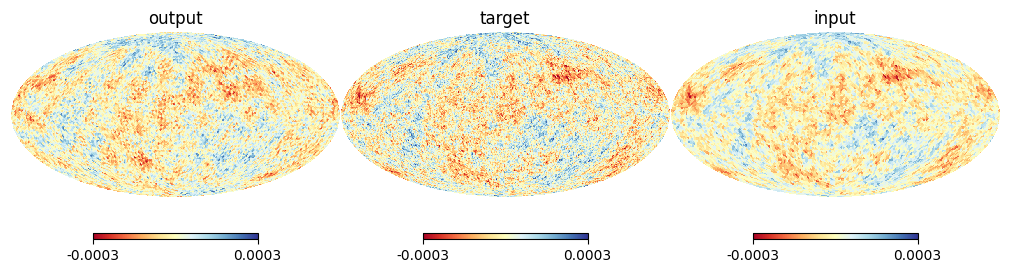

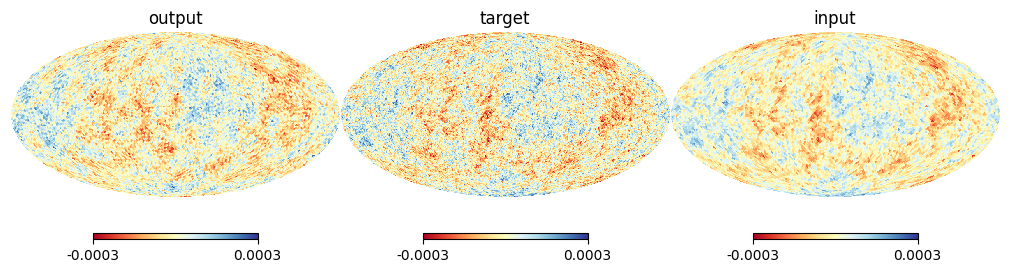

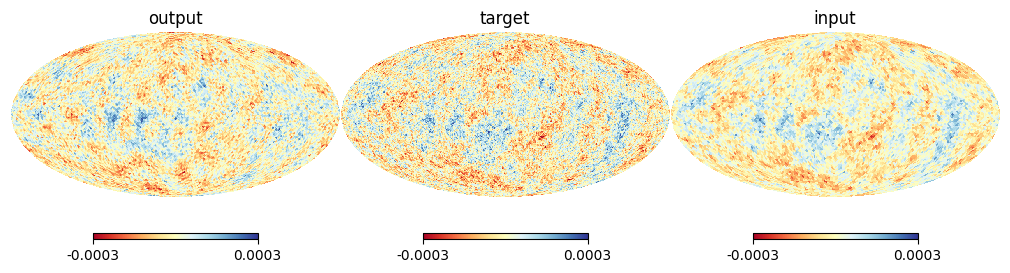

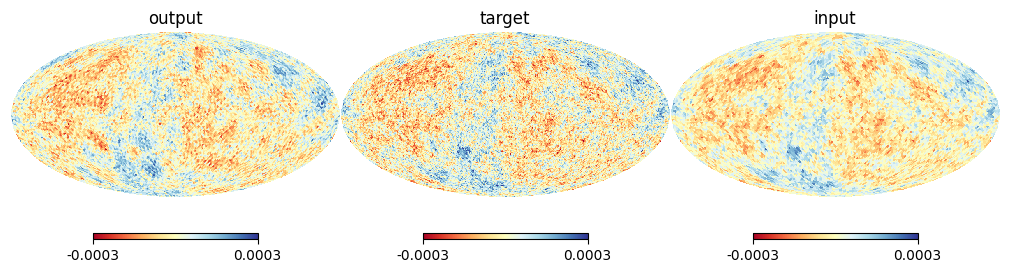

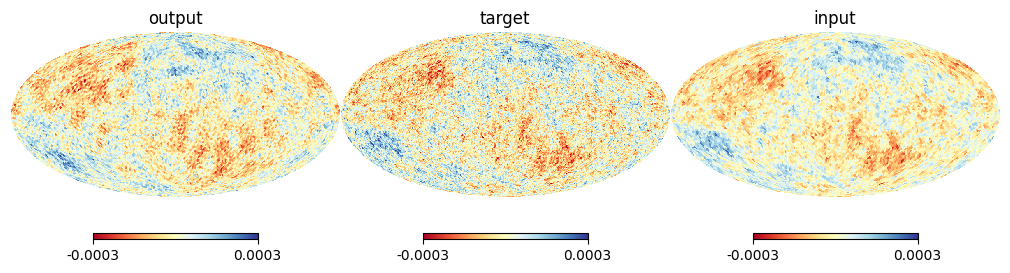

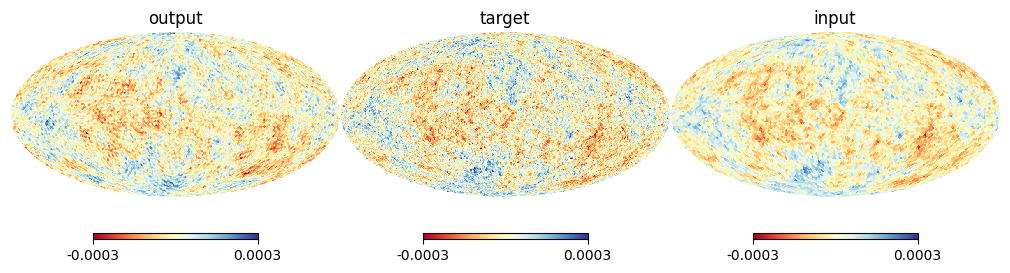

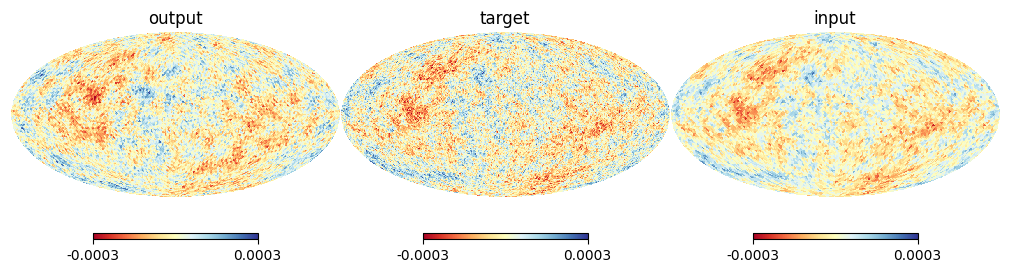

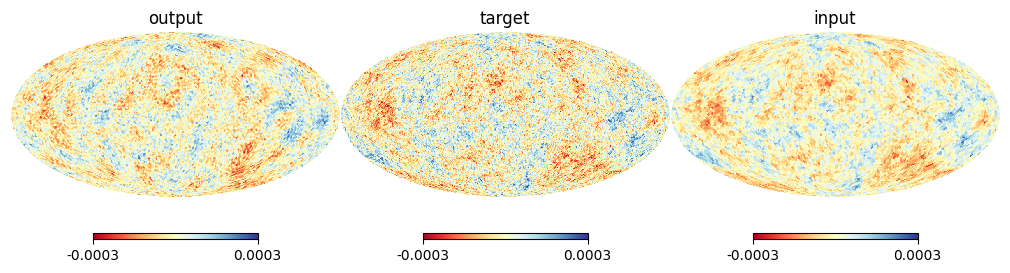

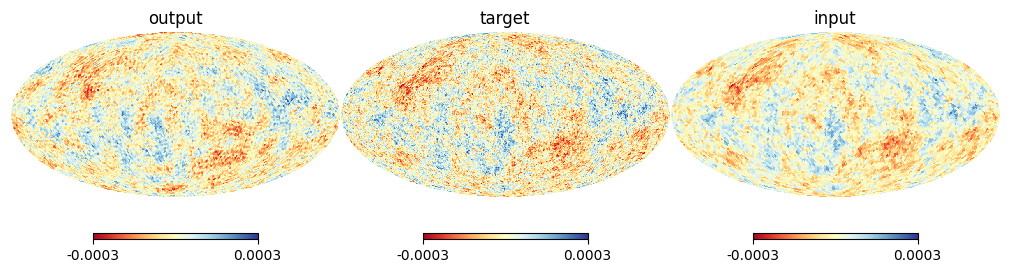

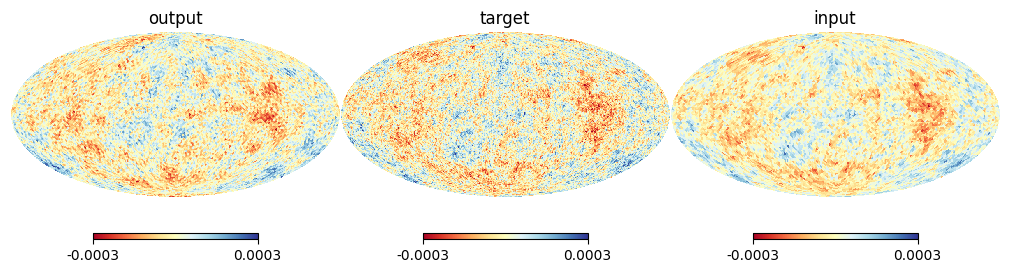

In [17]:
for i in range(n_maps):
    fig = plt.figure(figsize=(10,7))
    cm = plt.get_cmap("RdYlBu")
    cmin = -30*10e-6#min(np.min(data_test[j]), np.min(truth1[j]), np.min(test1[j]))
    cmax = 30*10e-6#max(np.max(data_test[j]), np.max(truth1[j]), np.min(test1[j]))

    ax2 = fig.add_axes([0.33, 0, 0.33, 1])
    plt.axes(ax2)
    hp.mollview(data_target[i], cmap="RdYlBu",hold=True, nest=True, title='target', min=cmin, max=cmax)

    ax3 = fig.add_axes([0.66, 0, 0.33, 1])
    plt.axes(ax3)
    hp.mollview(data_train[i], cmap="RdYlBu", hold=True, nest=True, title='input', min=cmin, max=cmax)
    
    pred = y_hat.detach().numpy().copy().reshape([y_hat.size(0),-1])[i]
    
    ax1 = fig.add_axes([0, 0, 0.33, 1])
    plt.axes(ax1)
    hp.mollview(-pred, cmap="RdYlBu", hold=True, nest=True,  title='output', min=cmin, max=cmax)
    
    plt.show()